# Previsão do preço do petróleo Brent (FOB) em US$

Pós-Tech Data Analytics – Fase 4  
Prova Substitutiva – Modelo preditivo + Deploy

Este notebook constrói um modelo de previsão para o preço diário do barril de petróleo bruto Brent (FOB), utilizando a série histórica disponibilizada pelo Ipeadata:

> http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view


In [1]:
!pip install pmdarima -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 11.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error

import joblib
import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")


In [3]:
url = "http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view"

# Vamos ler todas as tabelas da página neste primeiro momento
tabelas = pd.read_html(url, decimal=",", thousands=".")

len(tabelas), type(tabelas[0])


(5, pandas.core.frame.DataFrame)

In [4]:
# Vou verificar qual a tabela ele irá me trazer do site
df_raw = tabelas[-1].copy()
df_raw.head()


,0,1
0,PreÃ§o - petrÃ³leo bruto - Brent (FOB),NaN


In [5]:
# Para me certificar de trabalhar com a tabela correta, vou enumera-las para verificar seu cabeçalho
for i, tab in enumerate(tabelas):
    print(f"\n\n========== TABELA {i} ==========")
    print(tab.head())




========== TABELA 0 ==========
    0                                                  1
0 NaN  PreÃ§o por barril do petrÃ³leo bruto Brent (FO...


========== TABELA 1 ==========
                                                   0
0  Data  PreÃ§o - petrÃ³leo bruto - Brent (FOB)  ...


========== TABELA 2 ==========
            0                                       1
0        Data  PreÃ§o - petrÃ³leo bruto - Brent (FOB)
1  24/11/2025                                   64.83
2  21/11/2025                                   62.78
3  20/11/2025                                   63.64
4  19/11/2025                                   63.78


========== TABELA 3 ==========
      0   1
0  Data NaN


========== TABELA 4 ==========
                                        0   1
0  PreÃ§o - petrÃ³leo bruto - Brent (FOB) NaN


In [9]:
df_raw = tabelas[2].copy()
df_raw.head()
 # A tabela correta é a 2, depois de confirmarmos acima


,0,1
0,Data,PreÃ§o - petrÃ³leo bruto - Brent (FOB)
1,24/11/2025,64.83
2,21/11/2025,62.78
3,20/11/2025,63.64
4,19/11/2025,63.78


In [11]:
df = df_raw.copy()

# Vamos renomear as colunas
df.columns = ["Data", "Preco_Brent_FOB"]

# Aqui iremos remover linhas onde "Data" aparece como valor (sujeira)
df = df[df["Data"] != "Data"]

# Agora sim converte
df["Data"] = pd.to_datetime(df["Data"], dayfirst=True)
df["Preco_Brent_FOB"] = df["Preco_Brent_FOB"].astype(float)

# Ordena e limpa pra gente
df = df.sort_values("Data").dropna()
df = df.drop_duplicates(subset="Data")
df.set_index("Data", inplace=True)

df.head()


,Preco_Brent_FOB
Data,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63


In [15]:
# Aqui quero visualizar o que temos disponivel, mesmo que saia com números altos
print("Período disponível da série:")
print(f"Início: {df.index.min().date()}")
print(f"Fim   : {df.index.max().date()}")
print(f"Total de registros: {df.shape[0]}")

df["Preco_Brent_FOB"].describe()


Período disponível da série:
Início: 1987-05-20
Fim   : 2025-11-24
Total de registros: 11558


,Preco_Brent_FOB
count,11558.000000
mean,53.706248
std,32.890136
min,9.100000
25%,20.885000
50%,50.370000
75%,76.580000
max,143.950000


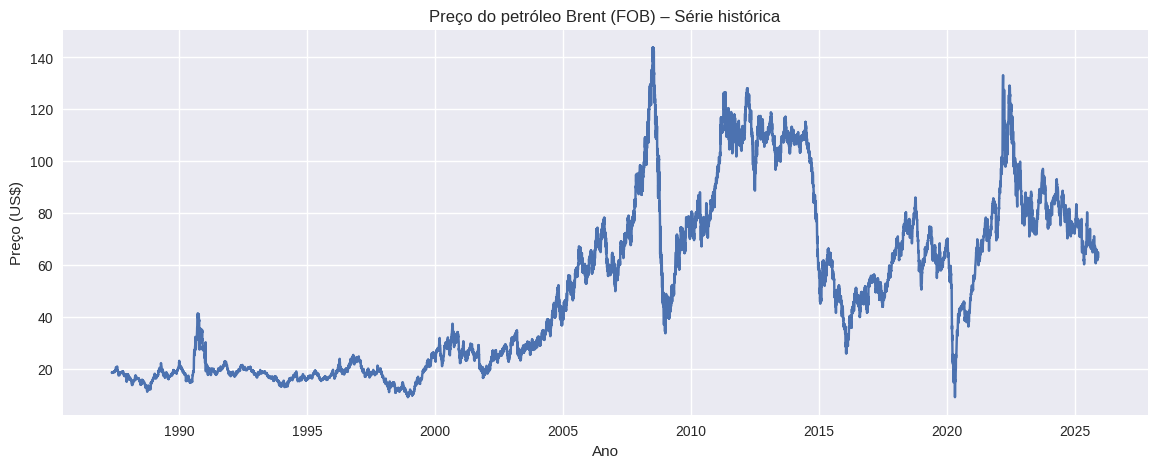

In [14]:
#Vamos gerar uma breve visualização sobre o historico que temos pra visualizar melhor
plt.figure(figsize=(14,5))
plt.plot(df.index, df["Preco_Brent_FOB"])
plt.title("Preço do petróleo Brent (FOB) – Série histórica")
plt.xlabel("Ano")
plt.ylabel("Preço (US$)")
plt.grid(True)
plt.show()


In [17]:
#Acredito ser o ideal rodar um teste com os 365 dias anteriores para essa série temporal
n_test = 365

train = df.iloc[:-n_test]
test  = df.iloc[-n_test:]

train.shape, test.shape


((11193, 1), (365, 1))

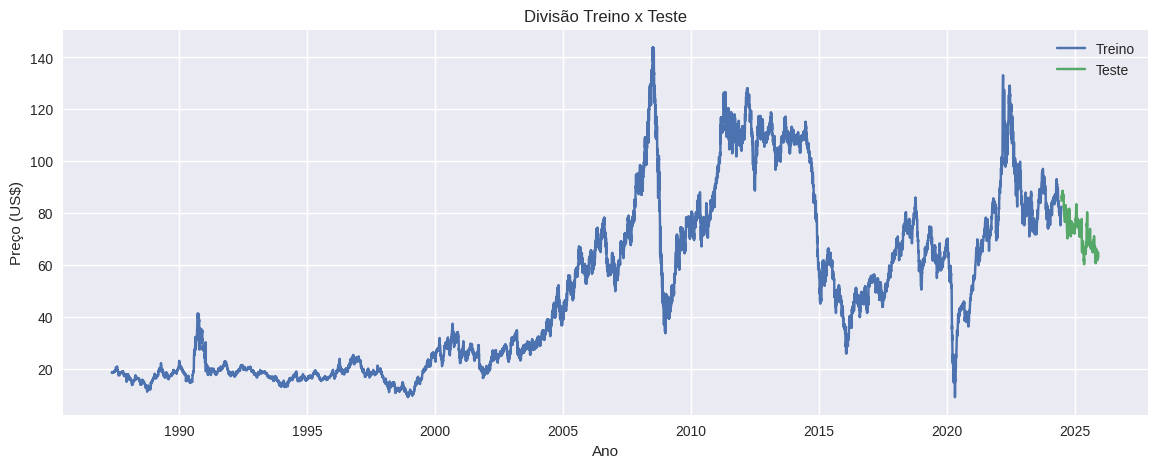

In [19]:
#Vamos verificar o que o trein acima nos da em questão de visualização
plt.figure(figsize=(14,5))
plt.plot(train.index, train["Preco_Brent_FOB"], label="Treino")
plt.plot(test.index, test["Preco_Brent_FOB"], label="Teste")
plt.title("Divisão Treino x Teste")
plt.xlabel("Ano")
plt.ylabel("Preço (US$)")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
#Depois do teste acima, vamos treinar nosso arima com auto_arima, e melhorar nossa busca pelos melhores parâmetros
modelo_arima = auto_arima(
    train["Preco_Brent_FOB"],
    seasonal=False,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

modelo_arima.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=39408.483, Time=10.61 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=40164.686, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=39982.017, Time=0.48 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=39864.088, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=40162.858, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=39569.186, Time=3.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=39488.372, Time=3.82 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=39368.504, Time=11.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=39394.601, Time=6.22 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=39353.587, Time=14.52 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=39356.711, Time=9.78 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=39345.866, Time=29.43 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=39344.811, Time=27.02 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=39356.838, Time=2.37 sec
 ARIMA(4,1,0)(

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11193
Model:               SARIMAX(5, 1, 1)   Log Likelihood              -19664.513
Date:                Mon, 01 Dec 2025   AIC                          39343.025
Time:                        01:48:07   BIC                          39394.286
Sample:                             0   HQIC                         39360.280
                              - 11193                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7776      0.018     42.218      0.000       0.741       0.814
ar.L2         -0.0401      0.008     -5.144      0.000      -0.055      -0.025
ar.L3          0.1243      0.008     16.093      0.000       0.109       0.139
ar.L4          0.1538      0.006     25.234      0.000       0.142       0.166
ar.L5         -0.0780      0.006    -12.162      0.000      -0.091      -0.065
ma.L1         -0.9417      0.018    -53.045      0.000      -0.976      -0.907
sigma2         1.9662      0.011    173.413      0.000       1.944       1.988
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             40404.71
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               8.60   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
#Depois disso, agora vamos prever esta amostra acima no conjunto de nosos teste
n_periods = len(test)

previsoes_test = modelo_arima.predict(n_periods=n_periods)
previsoes_test = pd.Series(previsoes_test, index=test.index)

previsoes_test.head()


,0
Data,
2024-06-18,NaN
2024-06-19,NaN
2024-06-20,NaN
2024-06-21,NaN
2024-06-24,NaN


In [23]:
#TIvemos um problema aqui, pois ele retonou como Nan, talvez haja alguma sujeira dentro que não foi removida, vamos tentar de uma forma que limpe e acabe com essas Nan para conseguirmos seguir
# Então aqui vamos ao número de pontos que queremos prever (tamanho do teste)
n_periods = len(test)

# Vamos fazer a previsão para n_periods à frente
preds_array = modelo_arima.predict(n_periods=n_periods)

# Vamos garantir que é um array de floats
preds_array = np.array(preds_array, dtype=float)

# Cria a série de previsões alinhada ao índice do teste
previsoes_test = pd.Series(preds_array, index=test.index, name="Previsto")

print("Total de previsões:", len(previsoes_test))
print("Nº de NaNs nas previsões:", previsoes_test.isna().sum())
previsoes_test.head()


Total de previsões: 365
Nº de NaNs nas previsões: 0


,Previsto
Data,
2024-06-18,82.246038
2024-06-19,82.167770
2024-06-20,82.170274
2024-06-21,82.293755
2024-06-24,82.273670


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Garante que só usamos linhas sem NaN em nenhuma das duas séries
dados_metricas = pd.concat(
    [test["Preco_Brent_FOB"].rename("Real"), previsoes_test],
    axis=1
).dropna()

y_true = dados_metricas["Real"]
y_pred = dados_metricas["Previsto"]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100

print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MAPE: {mape:.2f}%")



RMSE: 11.5503
MAE : 10.1616
MAPE: 14.69%


In [26]:
#Obtemos resultados consistentes acima depois de um breve ajuste, vamos agora treinar todo o modelo
modelo_final = auto_arima(
    df["Preco_Brent_FOB"],
    seasonal=False,
    trace=False,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

modelo_final.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                11558
Model:               SARIMAX(4, 1, 0)   Log Likelihood              -20331.027
Date:                Mon, 01 Dec 2025   AIC                          40672.054
Time:                        02:00:22   BIC                          40708.829
Sample:                             0   HQIC                         40684.413
                              - 11558                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1522      0.005    -29.892      0.000      -0.162      -0.142
ar.L2         -0.1844      0.005    -35.075      0.000      -0.195      -0.174
ar.L3         -0.0567      0.005    -11.786      0.000      -0.066      -0.047
ar.L4          0.0938      0.005     17.457      0.000       0.083       0.104
sigma2         1.9749      0.011    176.063      0.000       1.953       1.997
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             38417.73
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               8.14   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
#Legal, agora vamos prever 15 dias à frente a partir da última data da série... retornando um DataFrame com Data e Preco_Previsto.
def prever_preco_petroleo(modelo, serie, dias_futuros=30):

    previsoes = modelo.predict(n_periods=dias_futuros)

    datas_futuras = pd.date_range(
        start=serie.index[-1] + pd.Timedelta(days=1),
        periods=dias_futuros,
        freq="D"
    )

    return pd.DataFrame({
        "Data": datas_futuras,
        "Preco_Previsto": previsoes
    })


In [29]:
#Vamos a 60 dessa vez
previsao_60 = prever_preco_petroleo(modelo_final, df, dias_futuros=60)
previsao_60.head()


,Data,Preco_Previsto
11558,2025-11-25,64.583225
11559,2025-11-26,64.278319
11560,2025-11-27,64.173323
11561,2025-11-28,64.451899
11562,2025-11-29,64.422995


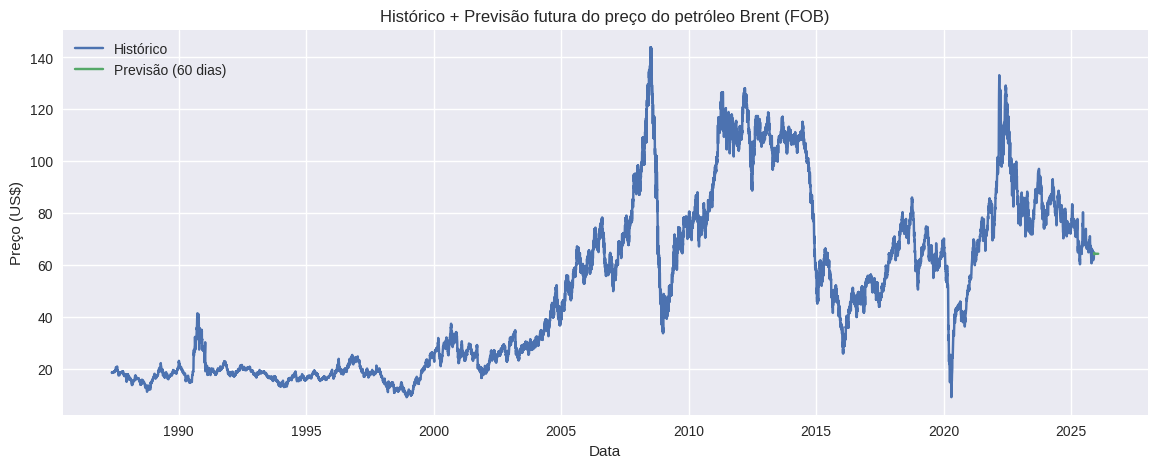

In [30]:
#E nossa cereja do bolo, é plotar a previsão para 60 dias
plt.figure(figsize=(14,5))
plt.plot(df.index, df["Preco_Brent_FOB"], label="Histórico")
plt.plot(previsao_60["Data"], previsao_60["Preco_Previsto"], label="Previsão (60 dias)")
plt.title("Histórico + Previsão futura do preço do petróleo Brent (FOB)")
plt.xlabel("Data")
plt.ylabel("Preço (US$)")
plt.legend()
plt.grid(True)
plt.show()


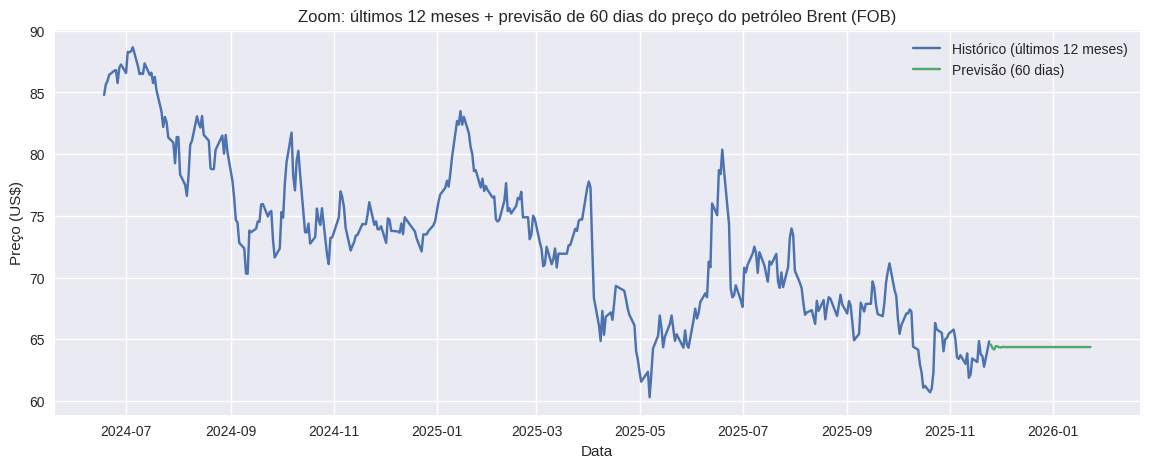

In [31]:
# A visulização ficou péssima no plot acima pela quantidade de anos no eixo x... então vamos dar um zoom nos últimos 365 dias + previsão de 60 dias e com certeza ira melhorar
janela = 365

data_inicio_zoom = df.index[-janela]

plt.figure(figsize=(14,5))
plt.plot(df.loc[data_inicio_zoom:].index,
         df.loc[data_inicio_zoom:, "Preco_Brent_FOB"],
         label="Histórico (últimos 12 meses)")

plt.plot(previsao_60["Data"],
         previsao_60["Preco_Previsto"],
         label="Previsão (60 dias)")

plt.title("Zoom: últimos 12 meses + previsão de 60 dias do preço do petróleo Brent (FOB)")
plt.xlabel("Data")
plt.ylabel("Preço (US$)")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
#Como solicitado, vamos salvar um arquivo pkl para levar ao streamlit
import joblib

joblib.dump(modelo_final, "modelo_petroleo_brent_arima.pkl")

print("Modelo salvo como 'modelo_petroleo_brent_arima.pkl'")


Modelo salvo como 'modelo_petroleo_brent_arima.pkl'
